In [742]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from physlearn import Regressor
from sklearn.svm import LinearSVC
import os
import cv2
import re

## Формировние синтетического датасета датасета на основе правил данных после спектрофотометрии

In [1049]:
# Формирование коэффициентов ар, ал, раз, окис
# формирование всех D
# начальные значения 
chem_dict = {"D720":23,"D1600":[],"D1375":[],"D1380":[],"D1700":[],"D2100":500}

# формирование D1600
start_value = 50
step = (chem_dict["D2100"]-start_value)/1000
for index in range(1000):
    chem_dict["D1600"].append(start_value+(step*index))
    
# формирование D1375
start_value = 2
step = (chem_dict["D1600"][0]-start_value)/1000
for index in range(1000):
    chem_dict["D1375"].append(start_value+(step*index))
    
# формирование D1380   
chem_dict["D1380"] = 0.3*chem_dict["D720"]

# формирование D1700  
chem_dict["D1700"] = [x*0.54 for x in chem_dict["D1375"]]

In [1050]:
# Теперь высчитываем коэффициенты + некоторые вычисления для "шума" в данных
noise = np.random.normal(0,1,1000)
df_coef = pd.DataFrame()
df_coef["Ароматичность"] = [(x/chem_dict["D2100"])+abs(noise[index]/10) for index,x in enumerate(chem_dict["D1600"])]
df_coef["Алифатичность"] = [((values[0]+chem_dict["D720"])/values[1])+np.exp(abs(noise[index]))
                            for index,values in enumerate(zip(chem_dict["D1375"],[10+index*0.01 for index in range(1000)]))]

df_coef["Разветвленность"] = (df_coef["Ароматичность"].apply(lambda x:np.power(x,-2)))/chem_dict["D1380"]
df_coef["Окисленность"] = [np.power((values[0]/values[1])+0.4,2)+abs(noise[index])/50 for index,values in enumerate(zip(chem_dict["D1700"],chem_dict["D1600"]))]

In [1051]:
df_coef.sample(5)

,Ароматичность,Алифатичность,Разветвленность,Окисленность
603,0.643135,4.369554,0.350385,0.204390
64,0.193871,4.075559,3.855913,0.196268
500,0.586828,4.711910,0.420852,0.210816
768,0.977923,9.969434,0.151545,0.242599
399,0.503311,4.711957,0.572108,0.211125


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB95D52B20>,
      dtype=object)

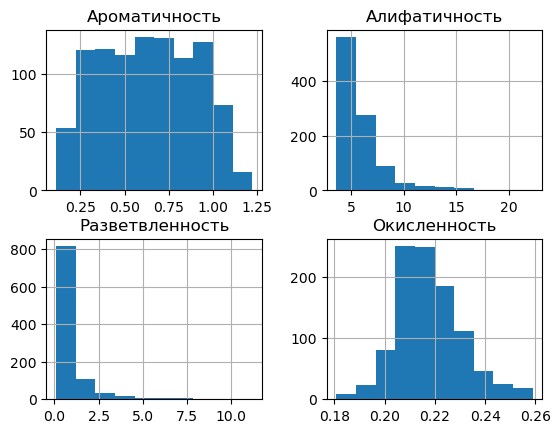

In [1052]:
df_coef.hist()

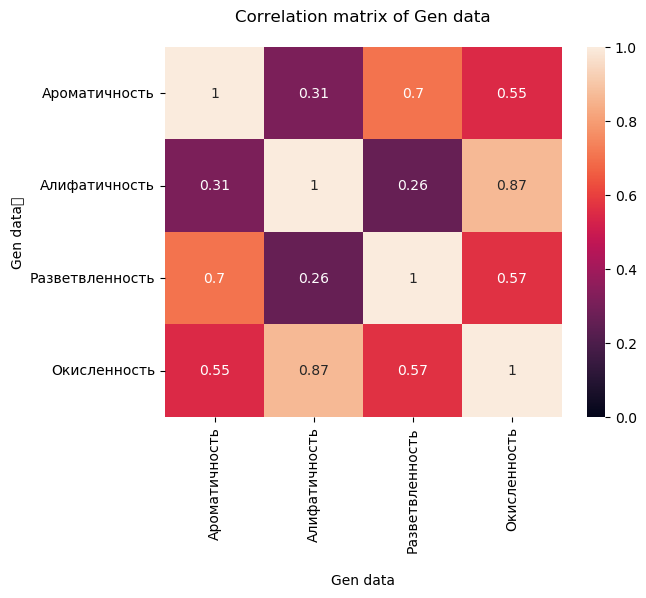

In [1053]:
# Матрица корреляции
import seaborn as sns
import matplotlib.pyplot as plt

hm = sns.heatmap(df_coef.corr().abs(), annot = True,vmax=1.0,vmin=0)
hm.set(xlabel='\nGen data', ylabel='Gen data\t', title = "Correlation matrix of Gen data\n")
plt.show()

In [1054]:
# Функция для задания других параметров
def feature_func(df_coef):
    coef1 = [0.03, 0.4, 0.003, 0.001]
    coef2 = [0.002, 0.001, 0.03, 0.14]
    coef3 = [0.001, 0.002, 0.1, 0.099]
    coef4 = [0.111, 0.2323, 0.00223, 0.01111]
    noise = abs(np.random.normal(0,1,1000))
    df_petrol_compounds = pd.DataFrame()
    df_petrol_compounds["содержание серы"] = (coef1[0]*df_coef.iloc[:, 0] + coef1[1]*df_coef.iloc[:, 1]+ coef1[2]*df_coef.iloc[:, 2] +coef1[3]*df_coef.iloc[:, 3])+noise/100
    df_petrol_compounds["плотность"] = np.abs(coef2[0]*df_petrol_compounds.iloc[:, 0] + coef2[1]*df_coef.iloc[:, 2]+coef2[2]*df_coef.iloc[:, 1]+coef2[3]*df_coef.iloc[:, 0])+noise/60
    df_petrol_compounds["вязкость"] = np.abs(coef3[0]*df_coef.iloc[:, 2] +coef3[1]*df_petrol_compounds.iloc[:, 1] +coef3[2]*df_coef.iloc[:, 3] +coef3[3]*df_coef.iloc[:, 0])+noise/50
    df_petrol_compounds["процент неразд. эмульсии"] = np.abs(coef4[0]*df_coef.iloc[:, 1] + coef4[1]*df_coef.iloc[:, 3] +coef4[2]*df_coef.iloc[:, 0] +coef4[3]*df_petrol_compounds.iloc[:, 2])+noise/10
    
    return pd.concat([df_coef,df_petrol_compounds], axis=1)

In [1055]:
# формирование - содеражния серы, вязкости, плотности и эмульсии
df_petrol_compounds = pd.DataFrame()
df = feature_func(df_coef)

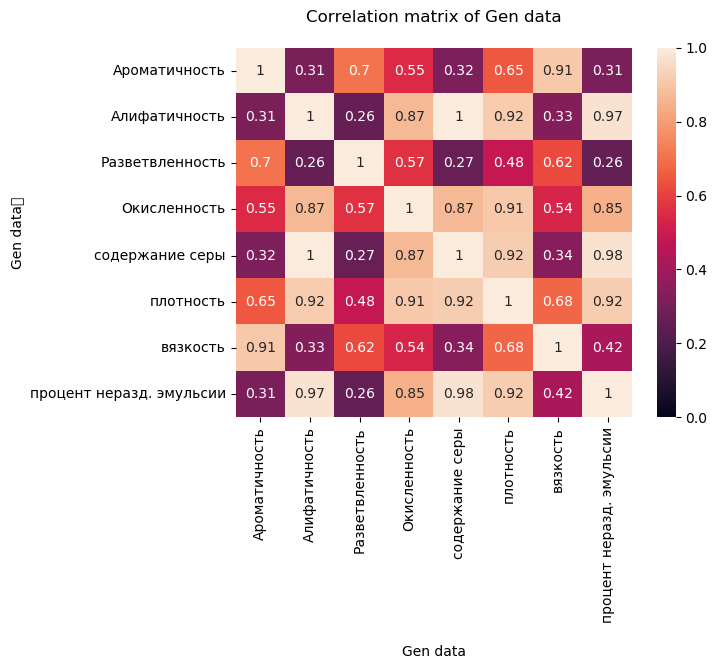

In [1056]:
# Матрица корреляции

import seaborn as sns
import matplotlib.pyplot as plt

hm = sns.heatmap(df.corr().abs(), annot = True,vmax=1.0,vmin=0)
hm.set(xlabel='\nGen data', ylabel='Gen data\t', title = "Correlation matrix of Gen data\n")
plt.show()

In [1057]:
# Вывод пяти рандомных строк
df.sample(5)

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии
48,0.299352,7.371385,1.617289,0.218252,2.973015,0.287965,0.074475,0.974525
756,0.786472,4.552810,0.234306,0.206412,1.850640,0.258980,0.109280,0.606406
204,0.297854,4.042895,1.633599,0.200792,1.631423,0.168262,0.051992,0.498924
983,1.096105,6.686825,0.120627,0.228346,2.720287,0.379760,0.156397,0.920302
400,0.582082,6.547116,0.427742,0.226713,2.648724,0.301806,0.103140,0.890894


In [1058]:
# класстеризация на 2 класса химии
from sklearn.cluster import KMeans
from collections import Counter

kmeans = KMeans(n_clusters=2,n_init=10, max_iter=300,random_state=42)
kmeans.fit(df)
df["класс химии"] = kmeans.labels_
print(Counter(df["класс химии"]).keys()) # equals to list(set(...))
print(Counter(df["класс химии"]).values()) # counts the elements' frequency

dict_keys([0, 1])
dict_values([922, 78])


In [1059]:
# создать списки процентов, которые одинаково ложаться на кол-во образцов химии разных классов
chem_rate = []
for class_count in Counter(df["класс химии"]).values():
    chem_rate.append([i for i in [5,10,15,20] for _ in range(class_count//4)])
    
# Просто сформиоовать поле процента
df["прооцент химии"] = 5

In [1060]:
# присвоить каждому классу лист равно равпредленого процента химии этого класса
num_values_per_class = list(Counter(df["класс химии"]).values())
for index,class_num in enumerate(Counter(df["класс химии"]).keys()):
    len_1 = num_values_per_class[index]
    len_2 = len(chem_rate[index])
    if len_1!=len_2:
        # присваиваем по дефолту 10 процентов на расширении
        chem_rate[index].extend([10]*(len_1-len_2))
    df.loc[df['класс химии'] == class_num, 'прооцент химии'] = chem_rate[index]

In [1061]:
# Создание переменных
df["Ароматичность-(химия)"] = 0
df["Алифатичность-(химия)"] = 0
df["Разветвленность-(химия)"] = 0
df["Окисленность-(химия)"] = 0

df["содержание серы-(химия)"] = 0
df["плотность-(химия)"] = 0
df["вязкость-(химия)"] = 0
df["процент неразд. эмульсии-(химия)"] = 0

In [1062]:
# Функция для задания выходных параметров
def output_func(df):
    noise = 0.39
    # noise = abs(np.random.normal(0,1,1000))
    # для класса -1 будет применятся sin
    # для класса -2 будет применятся sinc
    
    # для процента -5 будет применятся exp
    # для процента -10 будет применятся pow
    # для процента -15 будет применятся ln
    # для процента -20 будет применятся sqrt
    
    chem_class_list = sorted(list(Counter(df["класс химии"]).keys()))
    for chm_cls in chem_class_list:
        for chem_rate in [5,10,15,20]:
            # 1st class
            if chm_cls==0:
                if chem_rate==5:
                    # изменения по коэффициентам  
                    df.loc[(df['класс химии'] == chm_cls) & 
                           (df['прооцент химии'] == chem_rate), 
                           df.columns[10:18]] = (np.abs(np.sin(np.pi*df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])*np.exp(3))+noise).values
                if chem_rate==10:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls) & 
                           (df['прооцент химии'] == chem_rate),  df.columns[10:18]] = (np.abs(np.sin(np.pi*df.loc[(df['класс химии'] == chm_cls) & 
                                                                                                     (df['прооцент химии'] == chem_rate),df.columns[0:8]])/np.power(noise,3))+noise).values
                if chem_rate==15:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls) & 
                           (df['прооцент химии'] == chem_rate),  
                           df.columns[10:18]] = (np.abs(np.sin(np.pi*df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])/np.log(6))+noise).values
                if chem_rate==20:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls)
                           & (df['прооцент химии'] == chem_rate),
                           df.columns[10:18]] = (np.abs(np.sin(np.pi*df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])/np.sqrt(3))+noise).values
                # 2nd class
            if chm_cls==1:
                if chem_rate==5:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls) 
                           & (df['прооцент химии'] == chem_rate), 
                           df.columns[10:18]] = (np.abs(np.tan(np.pi/2+3)*(df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])*np.exp(3))+noise).values
                if chem_rate==10:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls) 
                           & (df['прооцент химии'] == chem_rate),
                           df.columns[10:18]] = (np.abs(np.tan(np.pi/2+3)*(df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])/np.power(0.39,3))+noise).values
                if chem_rate==15:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls)
                           & (df['прооцент химии'] == chem_rate), 
                           df.columns[10:18]] = (np.abs(np.tan(np.pi/2+3)*(df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])/np.log(6))+noise).values
                if chem_rate==20:
                    # изменения по коэффициентам        
                    df.loc[(df['класс химии'] == chm_cls) 
                           & (df['прооцент химии'] == chem_rate), 
                           df.columns[10:18]] = (np.abs(np.tan(np.pi/2+3)*(df.loc[(df['класс химии'] == chm_cls) & (df['прооцент химии'] == chem_rate),df.columns[0:8]])/np.sqrt(3))+noise).values
        
    return df

In [1063]:
# формирование полного датасета
df = output_func(df)

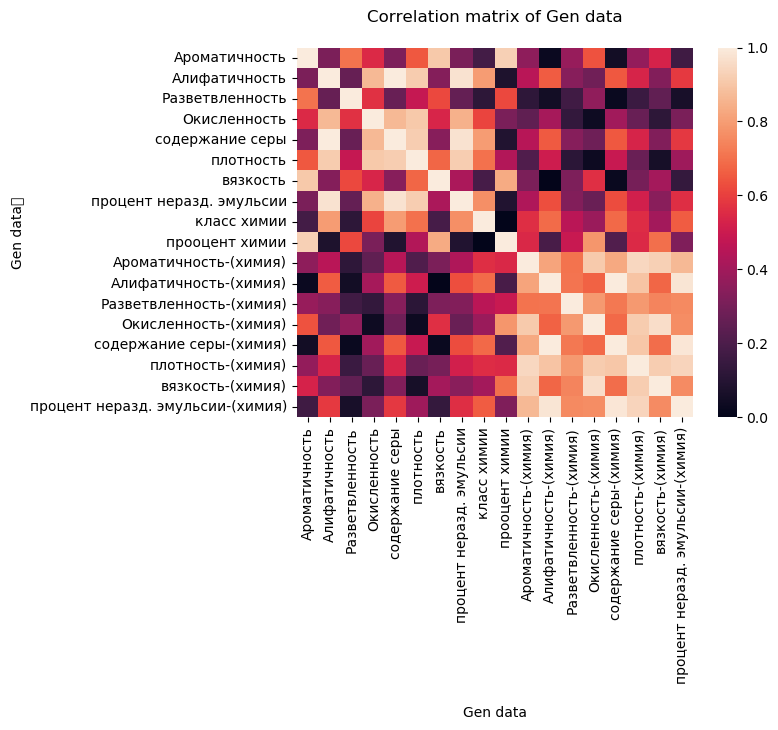

In [1064]:
# Матрица корреляции

import seaborn as sns
import matplotlib.pyplot as plt

hm = sns.heatmap(df.corr().abs(), annot = False,vmax=1.0,vmin=0)
hm.set(xlabel='\nGen data', ylabel='Gen data\t', title = "Correlation matrix of Gen data\n")
plt.show()

## EDA - анализ данных

### первичный подход

In [1065]:
df=pd.read_csv("data.csv")

# in dataset there are 2 empty rows as delimeter for classification
after_chem_columns = ["Ароматичность(химия)","Алифатичность(химия)","Разветвленность(химия)","Окисленность(химия)"," содержание серы(химия)",
              "плотность(химия)","вязкость(химия)","процент неразделяемой эмульсии(химия)"]
df = df.sample(frac=1)
df_train =df.iloc[:800,:] 
df_valid =df.iloc[800:,:] 
df_train.head()

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии,класс химии,прооцент химии,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
766,0.828337,4.973674,0.211221,0.213032,2.018444,0.274887,0.110624,0.637413,0,20,0.686487,0.437695,0.745609,0.748192,0.423434,0.828888,0.586635,0.914383
838,0.961425,6.470586,0.156791,0.227003,2.623867,0.344275,0.130911,0.835486,0,20,0.459796,0.964887,0.663025,0.767715,0.924185,0.899626,0.620808,0.675287
798,0.844565,4.822476,0.203182,0.210663,1.962762,0.279733,0.120671,0.663604,0,20,0.660856,0.695558,0.734010,0.744812,0.457388,0.834548,0.603667,0.892754
984,1.034106,5.264999,0.135525,0.215769,2.142831,0.315790,0.135093,0.690208,0,20,0.451743,0.817025,0.628456,0.752072,0.640461,0.873339,0.627742,0.867303
707,0.784976,5.079651,0.235200,0.214682,2.077383,0.301766,0.142127,0.827578,0,15,0.738987,0.528203,0.765875,0.738520,0.524348,0.843334,0.631001,0.677748


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB95EFE730>,
      dtype=object)

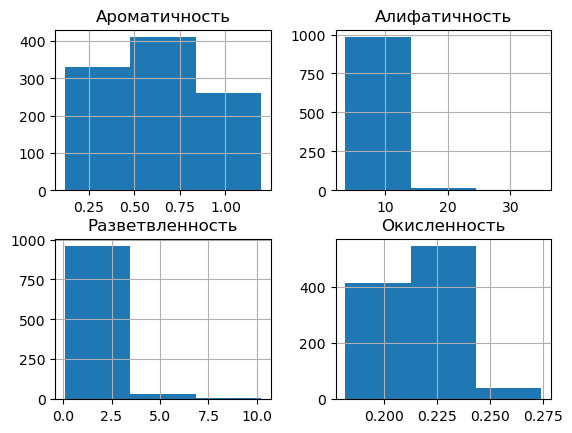

In [1066]:
#create histogram for each team
df.hist(column=["Ароматичность","Алифатичность","Разветвленность","Окисленность",],bins= 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB8961D370>,
      dtype=object)

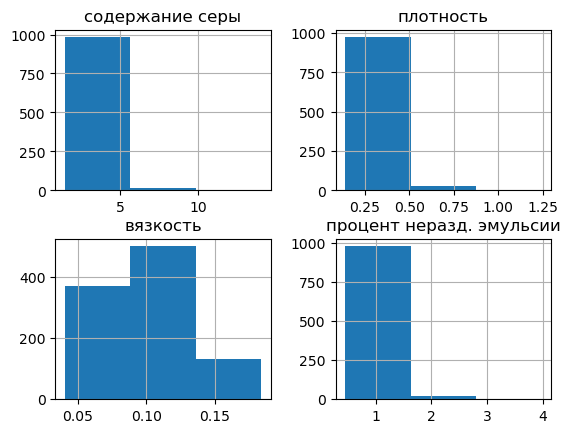

In [1067]:
#create histogram for each team
df.hist(column=["содержание серы","плотность","вязкость","процент неразд. эмульсии",],bins= 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB96A1C8E0>,
      dtype=object)

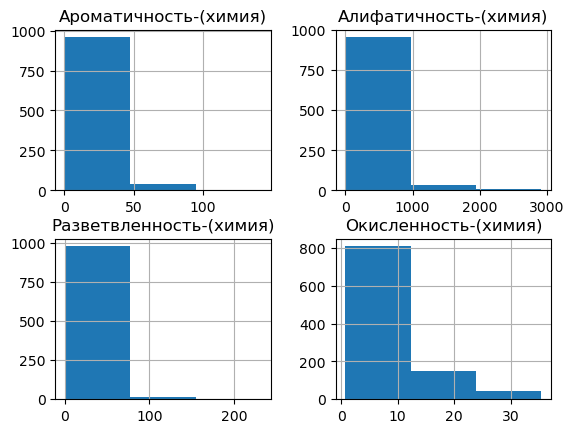

In [1068]:
#create histogram for each team
df.hist(column=["Ароматичность-(химия)","Алифатичность-(химия)","Разветвленность-(химия)","Окисленность-(химия)",],bins= 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB969CF4C0>,
      dtype=object)

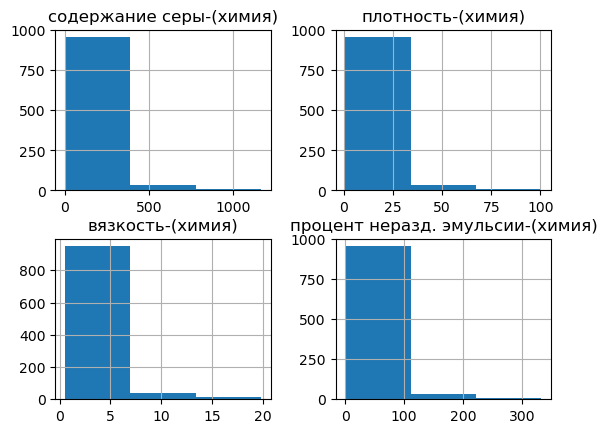

In [1069]:
#create histogram for each team
df.hist(column=["содержание серы-(химия)","плотность-(химия)","вязкость-(химия)","процент неразд. эмульсии-(химия)",],bins= 3)

In [1070]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 766 to 751
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ароматичность                     1000 non-null   float64
 1   Алифатичность                     1000 non-null   float64
 2   Разветвленность                   1000 non-null   float64
 3   Окисленность                      1000 non-null   float64
 4   содержание серы                   1000 non-null   float64
 5   плотность                         1000 non-null   float64
 6   вязкость                          1000 non-null   float64
 7   процент неразд. эмульсии          1000 non-null   float64
 8   класс химии                       1000 non-null   int64  
 9   прооцент химии                    1000 non-null   int64  
 10  Ароматичность-(химия)             1000 non-null   float64
 11  Алифатичность-(химия)             1000 non-null   float64
 12  Разве

In [1071]:
# Описание данных без столбцов класса химии и процента химии
df.describe(exclude=["int64"])

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.629207,5.955916,0.826316,0.217015,2.411848,0.285599,0.101210,0.793142,10.820967,73.720257,10.264707,7.140744,32.901126,8.667690,3.051958,15.385412
std,0.263489,2.453143,1.239355,0.013026,0.982605,0.093073,0.029432,0.281974,14.882850,317.813467,20.057823,7.467898,127.287895,12.284316,2.971154,38.347061
min,0.119118,3.608744,0.101377,0.181907,1.477501,0.140482,0.040802,0.452743,0.390131,0.392070,0.445562,0.724597,0.391877,0.750566,0.536932,0.395637
25%,0.409977,4.633480,0.200492,0.208414,1.880361,0.226064,0.077093,0.634362,0.692358,0.812620,0.742978,0.750292,0.672371,0.856881,0.607550,0.819885
50%,0.631232,5.212596,0.363725,0.215140,2.116731,0.274244,0.100514,0.727065,7.793694,3.830980,1.299366,10.372591,3.266975,9.188700,3.025483,5.556627
75%,0.850211,6.379339,0.862247,0.224741,2.585324,0.321683,0.124742,0.857719,16.985811,16.037218,16.136606,11.798471,14.384962,12.280787,4.795116,16.359185
max,1.195654,34.968281,10.213946,0.274264,14.024992,1.241811,0.183618,3.977397,141.791773,2914.683429,232.085393,35.418140,1168.565774,100.533310,19.852185,332.494415


In [1072]:
print("Разброс по кол-ву проделанных обработок по классу химии")

print("Класс 0 тренировочного набора",np.sum(df_train["класс химии"]==0))
print("Класс 1 тренировочного набора",np.sum(df_train["класс химии"]==1))

print("Класс 0 тестового набора",np.sum(df_valid["класс химии"]==0))
print("Класс 1 тестового набора",np.sum(df_valid["класс химии"]==1))

Разброс по кол-ву проделанных обработок по классу химии
Класс 0 тренировочного набора 727
Класс 1 тренировочного набора 73
Класс 0 тестового набора 187
Класс 1 тестового набора 13


Предсказываем нефть после обработки - 8 столбцов значений

In [1073]:
# Кусок кода взят отсюда: https://scikit-physlearn.readthedocs.io/en/latest/quick_start.html

bunch = load_linnerud(as_frame=True)  # returns a Bunch instance
X, y = df_train.iloc[:,:10], df_train.iloc[:,10:]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

transformer_list = [('pca', PCA(n_components=1)),
                    ('svd', TruncatedSVD(n_components=2))]
union = FeatureUnion(transformer_list=transformer_list, n_jobs=-1)

# Select a regressor, e.g., LGBMRegressor from LightGBM,
# with a case-insensitive string.
reg_odinary = Regressor(regressor_choice='lgbmregressor',
                pipeline_transform=('tr', union),
                scoring='neg_mean_absolute_error')

# Automatically build the pipeline with final estimator MultiOutputRegressor
# from Sklearn, then exhaustively search over the (hyper)parameters.
search_params = dict(reg__boosting_type=['gbdt', 'goss'],
                     reg__n_estimators=[6, 8, 10, 20])

reg_odinary.search(X_train, y_train, search_params=search_params,
           search_method='gridsearchcv')

# Generate predictions with the refit regressor, then
# compute the average mean absolute error.
y_pred = reg_odinary.fit(X_train, y_train).predict(X_test)
score = reg_odinary.score(y_test, y_pred)
print("Ошибка MAE", round(score['mae'].mean(),2))
print("Ошибка MSE", round(score['mse'].mean(),2))
print("Ошибка RMSE", round(score['rmse'].mean(),2))
print("Ошибка R2", round(score['r2'].mean(),2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
Ошибка MAE 13.91
Ошибка MSE 6541.8
Ошибка RMSE 43.21
Ошибка R2 0.8


In [1074]:
# Выведем предсказания
y_pred.columns = y_test.columns
y_pred.head()

,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
791,2.580435,-2.637117,-0.612588,1.619576,-6.134170,1.606430,0.975633,-2.109087
216,53.014668,1061.105044,77.186042,27.116971,452.104153,45.456309,10.585846,140.201959
210,15.824592,1.836318,9.304136,11.795622,0.739382,14.772669,4.499250,7.890891
61,11.654559,16.128566,12.839892,11.209582,20.135157,10.002878,3.820137,18.976009
306,16.105080,15.362310,14.255133,10.480975,8.434066,11.183571,4.796035,12.940432


### Проведем простую нормализацию

In [1075]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
df_scaled = pd.DataFrame(data=scaler.transform(df))
df_scaled.columns = df.columns

In [1076]:
df_train_scaled =df_scaled.iloc[:800,:] 
df_valid_scaled =df_scaled.iloc[800:,:] 
df_train_scaled.head()

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии,класс химии,прооцент химии,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
0,0.658798,0.043525,0.010862,0.337014,0.043112,0.122040,0.488895,0.052394,0.0,1.000000,0.002096,0.000016,0.001295,0.000680,0.000027,0.000785,0.002573,0.001562
1,0.782424,0.091259,0.005480,0.488287,0.091362,0.185043,0.630943,0.108590,0.0,1.000000,0.000493,0.000197,0.000939,0.001243,0.000456,0.001494,0.004342,0.000842
2,0.673872,0.038704,0.010067,0.311365,0.038674,0.126440,0.559241,0.059825,0.0,1.000000,0.001915,0.000104,0.001245,0.000583,0.000056,0.000842,0.003455,0.001497
3,0.849938,0.052815,0.003377,0.366651,0.053025,0.159179,0.660228,0.067372,0.0,1.000000,0.000436,0.000146,0.000790,0.000792,0.000213,0.001230,0.004701,0.001420
4,0.618520,0.046905,0.013233,0.354879,0.047809,0.146445,0.709479,0.106347,0.0,0.666667,0.002467,0.000047,0.001383,0.000401,0.000113,0.000930,0.004870,0.000849


In [1077]:
# Кусок кода взят отсюда: https://scikit-physlearn.readthedocs.io/en/latest/quick_start.html

bunch = load_linnerud(as_frame=True)  # returns a Bunch instance
X, y = df_train_scaled.iloc[:,:10], df_train_scaled.iloc[:,10:]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

# Select a regressor, e.g., LGBMRegressor from LightGBM,
# with a case-insensitive string.
reg_normalalized = Regressor(regressor_choice='lgbmregressor',
                pipeline_transform=('tr', union),
                scoring='neg_mean_absolute_error')

reg_normalalized.search(X_train, y_train, search_params=search_params,
           search_method='gridsearchcv')

# Generate predictions with the refit regressor, then
# compute the average mean absolute error.
y_pred = reg_normalalized.fit(X_train, y_train).predict(X_test)
score = reg_normalalized.score(y_test, y_pred)
print("Ошибка MAE", round(score['mae'].mean(),2))
print("Ошибка MSE", round(score['mse'].mean(),2))
print("Ошибка RMSE", round(score['rmse'].mean(),2))
print("Ошибка R2", round(score['r2'].mean(),2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
Ошибка MAE 0.02
Ошибка MSE 0.01
Ошибка RMSE 0.07
Ошибка R2 0.77


In [1078]:
# Восстановление изначальных данных до нормализации
predictions = pd.concat([X_test,y_pred],axis=1)
df_predictions = pd.DataFrame(data = scaler.inverse_transform(predictions))
df_predictions.columns = df.columns
df_predictions

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии,класс химии,прооцент химии,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
0,0.995611,9.794143,0.146208,0.242102,3.949103,0.442749,0.125601,1.155972,1.0,20.0,0.051211,-23.719452,2.258382,2.483869,-6.863925,2.966720,1.414860,2.251478
1,0.492534,10.160993,0.597419,0.237983,4.081939,0.383771,0.075395,1.192442,1.0,5.0,50.833537,1131.896680,85.207665,28.956147,454.566112,43.855383,10.957026,140.789717
2,0.397162,5.848621,0.918790,0.219785,2.362916,0.251000,0.079871,0.787791,0.0,5.0,17.293161,19.469467,6.348888,12.435830,17.863723,12.873769,5.115655,7.625078
3,0.184008,3.970106,4.280330,0.194490,1.608745,0.155941,0.046553,0.508263,0.0,5.0,10.540236,15.549005,11.675521,11.174435,20.627744,9.679714,3.482597,19.542499
4,0.449189,5.130412,0.718279,0.215471,2.068625,0.222677,0.068408,0.627429,0.0,10.0,16.203172,16.919925,13.326291,10.319935,9.161834,10.950076,4.017322,14.771801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.706395,5.272102,0.290439,0.217215,2.135093,0.268239,0.100426,0.678074,0.0,15.0,1.984327,8.614155,1.974299,1.481114,4.087703,1.707068,0.852390,2.472454
196,0.336325,5.134981,1.281243,0.213243,2.080918,0.227876,0.081915,0.748967,0.0,5.0,17.370018,20.721854,10.688625,12.229721,12.753909,13.223430,5.083673,13.901687
197,0.370462,4.205885,1.056000,0.203835,1.703910,0.194290,0.072646,0.586546,0.0,10.0,15.704960,20.092693,6.622286,10.098546,14.646490,10.135089,3.977719,16.702835
198,0.553637,6.580074,0.472825,0.226643,2.678749,0.328183,0.135533,1.070426,0.0,10.0,15.336589,16.464609,17.092368,11.266268,16.478279,14.180337,5.464769,12.831636


In [1079]:
# Проверяем метрику MAE нормализация
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_true = df_valid.iloc[:,10:]
data_valid_scaled = scaler.transform(df_valid)
data_valid_scaled = pd.DataFrame(data=data_valid_scaled)
y_pred = reg_normalalized.predict(data_valid_scaled.iloc[:,:10])

predictions = pd.concat([data_valid_scaled.iloc[:,:10],y_pred],axis=1)
df_predictions = pd.DataFrame(data = scaler.inverse_transform(predictions))
df_predictions.columns = df.columns
print("MAE", mean_absolute_error(y_true, df_predictions.iloc[:,10:]))
print("MSE", mean_squared_error(y_true, df_predictions.iloc[:,10:]))
print("RMSE", np.sqrt(mean_squared_error(y_true, df_predictions.iloc[:,10:])))
print("R2", r2_score(y_true, df_predictions.iloc[:,10:]))


MAE 7.478610191743583
MSE 3746.910000179395
RMSE 61.21200862722441
R2 0.8109602098605613


### Используем стандартизацию

In [1080]:
from sklearn.preprocessing import StandardScaler
scaler_standard = StandardScaler()
scaler_standard.fit(df)
df_scaled_standard = pd.DataFrame(data=scaler_standard.transform(df))
df_scaled_standard.columns = df.columns

In [1081]:
df_train_scaled_standard =df_scaled_standard.iloc[:800,:] 
df_valid_scaled_standard =df_scaled_standard.iloc[800:,:] 
df_train_scaled_standard.head()

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии,класс химии,прооцент химии,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
0,0.756121,-0.400602,-0.496551,-0.305932,-0.400569,-0.115145,0.320026,-0.552559,-0.306744,1.345586,-0.681291,-0.230699,-0.474820,-0.856433,-0.255279,-0.638434,-0.830168,-0.377559
1,1.261471,0.209905,-0.540491,0.767200,0.215880,0.630746,1.009642,0.150245,-0.306744,1.345586,-0.696530,-0.229039,-0.478940,-0.853817,-0.251343,-0.632673,-0.818660,-0.383797
2,0.817741,-0.462267,-0.503041,-0.487889,-0.457265,-0.063053,0.661545,-0.459628,-0.306744,1.345586,-0.683014,-0.229887,-0.475399,-0.856885,-0.255012,-0.637973,-0.824433,-0.378123
3,1.537449,-0.281787,-0.557658,-0.095689,-0.273916,0.324541,1.151817,-0.365232,-0.306744,1.345586,-0.697072,-0.229505,-0.480664,-0.855913,-0.253573,-0.634814,-0.816326,-0.378787
4,0.591475,-0.357380,-0.477193,-0.179196,-0.340556,0.173786,1.390923,0.122187,-0.306744,0.449723,-0.677762,-0.230414,-0.473809,-0.857728,-0.254486,-0.637257,-0.815228,-0.383733


In [1082]:
# Кусок кода взят отсюда: https://scikit-physlearn.readthedocs.io/en/latest/quick_start.html

bunch = load_linnerud(as_frame=True)  # returns a Bunch instance
X, y = df_train_scaled_standard.iloc[:,:10], df_train_scaled_standard.iloc[:,10:]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

# Select a regressor, e.g., LGBMRegressor from LightGBM,
# with a case-insensitive string.
reg_standardized = Regressor(regressor_choice='lgbmregressor',
                pipeline_transform=('tr', union),
                scoring='neg_mean_absolute_error')

reg_standardized.search(X_train, y_train, search_params=search_params,
           search_method='gridsearchcv')

# Generate predictions with the refit regressor, then
# compute the average mean absolute error.
y_pred = reg_standardized.fit(X_train, y_train).predict(X_test)
score = reg_standardized.score(y_test, y_pred)
print("Ошибка MAE", round(score['mae'].mean(),2))
print("Ошибка MSE", round(score['mse'].mean(),2))
print("Ошибка RMSE", round(score['rmse'].mean(),2))
print("Ошибка R2", round(score['r2'].mean(),2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
Ошибка MAE 0.27
Ошибка MSE 0.57
Ошибка RMSE 0.75
Ошибка R2 0.62


In [1083]:
# Восстановление изначальных данных до нормализации
predictions = pd.concat([X_test,y_pred],axis=1)
df_predictions = pd.DataFrame(data = scaler_standard.inverse_transform(predictions))
df_predictions.columns = df.columns
df_predictions

,Ароматичность,Алифатичность,Разветвленность,Окисленность,содержание серы,плотность,вязкость,процент неразд. эмульсии,класс химии,прооцент химии,Ароматичность-(химия),Алифатичность-(химия),Разветвленность-(химия),Окисленность-(химия),содержание серы-(химия),плотность-(химия),вязкость-(химия),процент неразд. эмульсии-(химия)
0,0.995611,9.794143,0.146208,0.242102,3.949103,0.442749,0.125601,1.155972,1.0,20.0,14.087188,46.368805,1.733384,3.631160,24.770986,4.856198,2.680371,12.316587
1,0.492534,10.160993,0.597419,0.237983,4.081939,0.383771,0.075395,1.192442,1.0,5.0,44.912550,1024.774810,76.616890,24.557595,413.843824,41.062999,9.303093,129.042197
2,0.397162,5.848621,0.918790,0.219785,2.362916,0.251000,0.079871,0.787791,0.0,5.0,17.895287,19.207772,8.904477,12.299841,16.902755,13.518620,5.057378,11.893360
3,0.184008,3.970106,4.280330,0.194490,1.608745,0.155941,0.046553,0.508263,0.0,5.0,7.483014,-48.623901,9.102412,9.800819,-8.177546,7.429426,3.179257,10.300401
4,0.449189,5.130412,0.718279,0.215471,2.068625,0.222677,0.068408,0.627429,0.0,10.0,15.824371,17.535103,9.909113,10.376013,11.206213,11.329120,4.218009,15.110316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.706395,5.272102,0.290439,0.217215,2.135093,0.268239,0.100426,0.678074,0.0,15.0,2.148444,8.394153,2.030165,1.592243,4.020676,1.757107,0.870395,2.445425
196,0.336325,5.134981,1.281243,0.213243,2.080918,0.227876,0.081915,0.748967,0.0,5.0,17.201450,20.054165,11.116614,12.128698,9.953015,12.985878,4.910749,15.752770
197,0.370462,4.205885,1.056000,0.203835,1.703910,0.194290,0.072646,0.586546,0.0,10.0,16.539931,19.107248,8.164814,10.203060,15.995771,9.992108,3.912932,16.473802
198,0.553637,6.580074,0.472825,0.226643,2.678749,0.328183,0.135533,1.070426,0.0,10.0,14.026392,15.939084,14.566098,9.045277,11.887693,11.986025,5.178100,7.568503


In [1084]:
# Проверяем метрику MAE стандартизация
from sklearn.metrics import mean_absolute_error
y_true = df_valid.iloc[:,10:]
data_valid_scaled = scaler_standard.transform(df_valid)
data_valid_scaled = pd.DataFrame(data=data_valid_scaled)
y_pred = reg_standardized.predict(data_valid_scaled.iloc[:,:10])

predictions = pd.concat([data_valid_scaled.iloc[:,:10],y_pred],axis=1)
df_predictions = pd.DataFrame(data = scaler_standard.inverse_transform(predictions))
df_predictions.columns = df.columns
print("MAE", mean_absolute_error(y_true, df_predictions.iloc[:,10:]))
print("MSE", mean_squared_error(y_true, df_predictions.iloc[:,10:]))
print("RMSE", np.sqrt(mean_squared_error(y_true, df_predictions.iloc[:,10:])))
print("R2", r2_score(y_true, df_predictions.iloc[:,10:]))


MAE 12.259922405917319
MSE 7314.882271536071
RMSE 85.5270850171808
R2 0.5923726782572435


In [1085]:
# save the model above
import pickle
file_model = "pickle_regression_model.pkl"
with open(file_model,'wb') as f:
    pickle.dump(reg_odinary, f)

Предсказываем химию полученной нефти на сгенерированных предсказаниях нефти после химии

In [109]:
chemisrty_classes = [1, 2, 3, 4, 5, 6]
percent_rate = [5, 10, 15, 20]
input_excel = "input_data.xlsx"
df = pd.read_excel(input_excel)

# output df to excel concatenated with class and chemistry percent rate
df_output = df.sample(frac=1).sample(n=5)

In [106]:
for index in range(5):
    data = pd.DataFrame(df_output.iloc[index, :]).transpose()
    prediction_dict = dict()
    for chm_class in np.sort(chemisrty_classes):
        data["класс химии"] = chm_class
        for rate in np.sort(percent_rate):
            data["процент химии"] = rate
            predictions = reg.predict(data).values
            prediction_dict[f"{chm_class}_{rate}_{index}"] = predictions[0]

    df_predictions = pd.DataFrame(prediction_dict.values())
    df_predictions["class"] = [int(key.split('_')[0]) for key in prediction_dict.keys()]
    df_predictions["%rate"] = [int(key.split('_')[1]) for key in prediction_dict.keys()]

    # Забиваем идеальную нефть и вытаскиваем ближайшего соседа - то есть класс нефти и процент
    # Это обратный подход, то есть мы как будто бы находим на самом деле какой класс и процент использовать,
    # чтобы максимально приблизиться к "Идеальному соотншению парметров в нефти"

    # targets - это слияние класса и процента химии

    # 7,8043, 11,099, 9,2492, 12,641, 8,2895, 835,22, 234,49, 29,635

    X_data = df_predictions.drop(columns=["class", "%rate"])
    y_data = df_predictions[["class", "%rate"]]
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_data, y_data)
    perfect_petrol = [7.8043, 11.099, 9.2492, 12.641, 8.2895, 835.22, 234.49, 29.635]
    prediction_class_percent = neigh.predict([perfect_petrol])
    df_output.iloc[index, 8] = prediction_class_percent[0][0]
    df_output.iloc[index, 9] = prediction_class_percent[0][1]


In [8]:
# save the model above
import pickle
file_model = "pickle_KNN_model.pkl"
with open(file_model,'wb') as f:
    pickle.dump(neigh, f)